# Using the forward and inverse kinematics

![Banner](banner.png)

This notebook illustrates how you can use the kinematic chains defined by the PoppyTorso class to directly control the arms of the robot in the cartesian space.

Said in a simpler way, this means that we will see how you can:
* **get the end effector position from the joint angles of the motors (forward kinematic)**
* **compute the joint angles needed to reach a specific cartesian point: i.e. a 3D position (inverse kinematic)**

This is a particularly useful and efficient technique, for instance if you want to grab an object in a specific position.

The Torso robots defines two kinematic chains, one for each arm. They are in the same coordinates system. The origin of both chain is the first link of the robot: the base. They are composed of 7 joints. For the left chain:
* abs_z
* bust_y
* bust_x
* **l_shoulder_y**
* **l_shoulder_x**
* **l_arm_z**
* **l_elbow_y**

The 3 first joints are passiv, they are part of the chain (this allows two share the same origin for both chains) but are not effectively used, they will not be moved.

The figure below shows you a plot of both kinematics chains of the Torso (in the zero position):

![IK chains of the Torso](./IK.png)

All examples below are given using V-REP as it is safer when playing with your robot. You do not risk to break anything, in the worst case all you need to do is reset the simulation :-) All the examples below can be directly switched to a real robot.

## Simple example using a real robot

First load you robot with the usual code:

In [1]:
from poppy.creatures import PoppyTorso

poppy = PoppyTorso()

Then, you can directly access the chains:

In [3]:
print(poppy.l_arm_chain)
print(poppy.r_arm_chain)

And their respective motors:

In [4]:
[m.name for m in poppy.l_arm_chain.motors]

[u'abs_z',
 u'bust_y',
 u'bust_x',
 u'l_shoulder_y',
 u'l_shoulder_x',
 u'l_arm_z',
 u'l_elbow_y']

For the next steps, the left arm will be set as "not compliant".

In [77]:
for m in poppy.l_arm_chain.motors:
    m.compliant = True

# Forward kinematics

You can directly retrieve the current cartesian position of the end effector of a chain. For instance, assuming your robot is still in the rest positions:

In [5]:
poppy.l_arm_chain.end_effector

array([ 0.21966554,  0.0908242 ,  0.12659155])

This means that the end of the left arm is 0.10 meters on the right of the base of the robot, 0.17 meters in front and 0.07 meters up. 

The end effector position is **computed** from the joints position and the kinematic model of the robot. It is thus a theoretical position, which may differs from the real position due to the model imperfections.

The joints position of a chain can also be directly retrieved (the values are expressed in degrees):

In [8]:
poppy.l_arm_chain.joints_position

[26.86, -25.1, 18.24, -8.900000000000006, -6.219999999999999, -4.62, 2.75]

### Plotting

Thanks to the [IKPy](https://github.com/Phylliade/ikpy) library, you can also directly plot a kinematic chain configuration using matplotlib.

For instance, you can plot the current position of your robot :

(-0.3, 0.3)

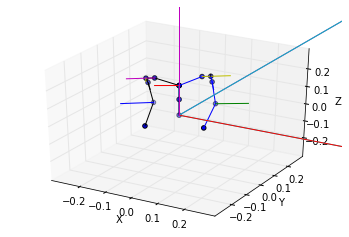

In [76]:
import matplotlib.pyplot
from mpl_toolkits.mplot3d import Axes3D

zero = [0] * 7

ax = figure().add_subplot(111, projection='3d')

poppy.l_arm_chain.plot(poppy.l_arm_chain.convert_to_ik_angles(poppy.l_arm_chain.joints_position), ax)
poppy.r_arm_chain.plot(poppy.r_arm_chain.convert_to_ik_angles(poppy.r_arm_chain.joints_position), ax)
xlim(-0.3, 0.3)
ylim(-0.3, 0.3)
ax.set_zlim3d([-0.3, 0.3])

*Note the use of the **convert_to_ik_angles** method which converts from pypot representation (using degrees, motor offset and orientation) to IKPy internal representation.*

# Inverse kinematics

You can also directly ask the robot, more precisely one of its kynematic chain, to reach a specific cartesian position. The [IKPy](https://github.com/Phylliade/ikpy) library will use an optimization technique to try to find the configuration of the joints that best match your target position.

For instance, if you want to move the robot left hand in front of its head, you can ask it to go the position [0, -0.15, 0.35]:

In [26]:
poppy.l_arm_chain.goto((0.0, -0.15, 0.35), 2., wait=True)

This is particularly useful when you want to directly control your robot in the cartesian space. For instance, it become rather easy to make the hand of the robot follow a circle:

In [31]:
import numpy as np
r = .2
x0, y0, z0 = (0.1, -0.15, 0.25)

poppy.l_arm_chain.goto((x0, y0, z0), 1., wait=True)


for alpha in np.arange(0, 2*np.pi, .1):
    x = r * np.cos(alpha) + x0
    z = r * np.sin(alpha) + z0
    
    poppy.l_arm_chain.goto((x, y0, z), .05, wait=False)

As you can see the movement may be jerky as each computation of the inverse kinematic takes some time.

 The optimizer used by IKPy can be tweaked depending on what you want to do. This is beyond the scope of this tutorial, please refer directly to [IKPy documentation](https://github.com/Phylliade/ikpy) for details.

Finally, thanks to widgets you can also easily design a user interface for directly controlling your robot's hand!

In [32]:
from ipywidgets import interact, FloatSlider


c = poppy.l_arm_chain

x, y, z = c.end_effector
size = 0.3

def goto(x, y, z):
    c.goto((x, y, z), .1)
    
interact(goto, 
         x=FloatSlider(min=x-size, max=x+size, value=x, step=0.01), 
         y=FloatSlider(min=y-size, max=y+size, value=y, step=0.01), 
         z=FloatSlider(min=z-size, max=z+size, value=z, step=0.01))